# Utilizando LLM não reasoner da OpenAI para classificar as imagens

In [1]:
# 1) Monte o Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import base64
import pandas as pd
from openai import OpenAI
from PIL import Image
import io
import random
from datetime import datetime
import tiktoken
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    classification_report
)
import matplotlib.pyplot as plt


In [4]:
BASE_DIR     = '/content/drive/MyDrive/MESTRADO'
IMAGES_DIR   = f"{BASE_DIR}/Brain Tumor/Brain Tumor"
CSV_FILE     = f"{BASE_DIR}/Brain Tumor.csv"
RESULTS_FILE = f"{BASE_DIR}/resultados_analise_tumor-4o.csv"

In [39]:
client = OpenAI(api_key="")

MAX_IMAGES = 3762  # Limite de imagens para análise

#Calcular valor gasto aproximadamente
COST_PER_1K_INPUT_TOKENS = 0.0011
COST_PER_1K_OUTPUT_TOKENS = 0.0044
COST_PER_IMAGE = 0.00255

In [40]:
def count_tokens(text, model=4o"):
    """Conta tokens em um texto usando tiktoken."""
    try:
        encoding = tiktoken.encoding_for_model("gpt-4")
        return len(encoding.encode(text))
    except Exception:
        # Fallback: estimativa baseada em caracteres (aproximadamente 4 chars = 1 token)
        return len(text) // 4

In [41]:
def calculate_estimated_cost(input_tokens, output_tokens, num_images):
    """Calcula o custo estimado da operação."""
    input_cost = (input_tokens / 1000) * COST_PER_1K_INPUT_TOKENS
    output_cost = (output_tokens / 1000) * COST_PER_1K_OUTPUT_TOKENS
    image_cost = num_images * COST_PER_IMAGE
    total_cost = input_cost + output_cost + image_cost
    return {
        'input_cost': input_cost,
        'output_cost': output_cost,
        'image_cost': image_cost,
        'total_cost': total_cost
    }

In [42]:
def encode_image_to_base64(image_path):
    """Converte uma imagem para base64."""
    try:
        with Image.open(image_path) as img:
            # Redimensiona a imagem para reduzir o tamanho se necessário
            img.thumbnail((512, 512))

            # Converte para RGB se necessário
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Salva em buffer de bytes
            buffer = io.BytesIO()
            img.save(buffer, format='JPEG', quality=85)
            img_data = buffer.getvalue()

            # Converte para base64
            return base64.b64encode(img_data).decode('utf-8')
    except Exception as e:
        error_type = type(e).__name__
        error_message = str(e)

        print(f"\n❌ ERRO DETALHADO no processamento da imagem {image_path}:")
        print(f"   Tipo do erro: {error_type}")
        print(f"   Mensagem: {error_message}")

        # Verifica tipos específicos de erro
        if 'cannot identify image file' in error_message.lower():
            print(f"   ERRO DE FORMATO - Arquivo não é uma imagem válida ou está corrompido")
        elif 'no such file or directory' in error_message.lower():
            print(f"   ERRO DE ARQUIVO - Arquivo não encontrado no caminho especificado")
        elif 'permission denied' in error_message.lower():
            print(f"   ERRO DE PERMISSÃO - Sem permissão para acessar o arquivo")
        elif 'memory' in error_message.lower():
            print(f"   ERRO DE MEMÓRIA - Imagem muito grande para processar")

        print(f"   Pulando esta imagem...\n")
        return None

In [43]:
def analyze_brain_image(image_base64, image_name):
    """Analisa uma imagem de cérebro usando 4o"""

    prompt_text = """You only have two options, if it is cancer write:

CLASSIFICATION: [TUMOR]

and if it is not, write

CLASSIFICATION: [NO_TUMOR].

YOU DO NOT HAVE ANOTHER OPTION do not say sorry, only TUMOR or NO_TUMOR"""

    messages = [
        {
            "role": "system",
            "content": "You answer [TUMOR] or [NO_TUMOR]."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt_text
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_base64}"
                    }
                }
            ]
        }
    ]

    # Conta tokens de entrada
    input_tokens = count_tokens(prompt_text)

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages
        )

        result = response.choices[0].message.content.strip()
        output_tokens = count_tokens(result)

        print(f"Resposta para {image_name}: {result}")
        print(f"Tokens - Entrada: {input_tokens}, Saída: {output_tokens}")

        return result, input_tokens, output_tokens

    except Exception as e:
        # Tratamento detalhado de erros da API OpenAI
        error_type = type(e).__name__
        error_message = str(e)

        print(f"\n❌ ERRO DETALHADO na análise da imagem {image_name}:")
        print(f"   Tipo do erro: {error_type}")
        print(f"   Mensagem: {error_message}")

        # Verifica se é um erro HTTP específico
        if hasattr(e, 'response'):
            print(f"   Status HTTP: {e.response.status_code}")
            if hasattr(e.response, 'json'):
                try:
                    error_json = e.response.json()
                    if 'error' in error_json:
                        print(f"   Detalhes da API: {error_json['error']}")
                except:
                    pass

        # Verifica se é um erro de rate limit
        if 'rate limit' in error_message.lower():
            print(f"   ERRO DE RATE LIMIT - Aguarde antes de tentar novamente")

        # Verifica se é um erro de autenticação
        if 'authentication' in error_message.lower() or 'api key' in error_message.lower():
            print(f"   ERRO DE AUTENTICAÇÃO - Verifique sua API key")

        # Verifica se é um erro de contexto/tokens
        if 'context' in error_message.lower() or 'token' in error_message.lower():
            print(f"   ERRO DE CONTEXTO/TOKENS - Imagem ou prompt muito grande")

        # Verifica se é um erro de modelo
        if 'model' in error_message.lower():
            print(f"   ERRO DE MODELO - Modelo pode não estar disponível")

        print(f"   Continuando com próxima imagem...\n")

        return f"ERRO: {error_type} - {error_message}", input_tokens, 0

In [44]:
def parse_gpt_response(response):
    """Extrai a classificação e justificativa da resposta do GPT (em inglês)."""
    try:
        lines = response.split('\n')
        classification = None
        justification = None

        for line in lines:
            line = line.strip()
            if line.startswith('CLASSIFICATION:'):
                classification = line.replace('CLASSIFICATION:', '').strip()
            elif line.startswith('JUSTIFICATION:'):
                justification = line.replace('JUSTIFICATION:', '').strip()

        # Normaliza a classificação
        if classification:
            if 'TUMOR' in classification.upper() and 'NO' not in classification.upper():
                classification = 'TUMOR'
            else:
                classification = 'NO_TUMOR'

        return classification, justification

    except Exception as e:
        print(f"Erro ao analisar resposta: {e}")
        return None, response

In [45]:
def main():
    try:
        print("Iniciando análise de imagens de tumor cerebral com 4o...")
        print("Modelo responde em INGLÊS (TUMOR/NO_TUMOR)")
        print(f"Configuração atual: {MAX_IMAGES} imagens (sempre as primeiras do dataset)")
        print("Para alterar a quantidade, modifique a variável MAX_IMAGES no início do código")

        # Carrega dados do CSV
        print("Carregando dados do CSV...")
        try:
            df_true = pd.read_csv(CSV_FILE)
        except FileNotFoundError:
            print(f"❌ ERRO: Arquivo CSV '{CSV_FILE}' não encontrado!")
            print(f"   Verifique se o arquivo existe no diretório atual")
            return
        except Exception as e:
            print(f"❌ ERRO ao carregar CSV: {type(e).__name__} - {e}")
            return

        # Verifica se o diretório de imagens existe
        if not os.path.exists(IMAGES_DIR):
            print(f"❌ ERRO: Diretório de imagens '{IMAGES_DIR}' não encontrado!")
            print(f"   Verifique se o caminho está correto")
            return

        # Prepara lista de imagens para análise
        images_to_analyze = []
        for _, row in df_true.iterrows():
            image_name = row['Image']
            true_class = row['Class']  # 0 = sem tumor, 1 = com tumor
            image_path = os.path.join(IMAGES_DIR, f"{image_name}.jpg")

            if os.path.exists(image_path):
                images_to_analyze.append({
                    'image_name': image_name,
                    'image_path': image_path,
                    'true_class': true_class,
                    'true_label': 'NO_TUMOR' if true_class == 0 else 'TUMOR'
                })

        if not images_to_analyze:
            print("❌ ERRO: Nenhuma imagem encontrada para análise!")
            print(f"   Verifique se existem arquivos .jpg no diretório '{IMAGES_DIR}'")
            return

        print(f"Encontradas {len(images_to_analyze)} imagens disponíveis")

        # Limita ao número máximo de imagens (sempre as primeiras)
        if len(images_to_analyze) > MAX_IMAGES:
            images_to_analyze = images_to_analyze[:MAX_IMAGES]  # Pega as primeiras N imagens
            print(f"Selecionadas as primeiras {MAX_IMAGES} imagens para análise")
        else:
            print(f"Analisando todas as {len(images_to_analyze)} imagens disponíveis")

        # Calcula estimativa de custo inicial
        estimated_input_tokens = count_tokens("""You only have two options, if it is cancer write:

CLASSIFICATION: [TUMOR]

and if it is not, write

CLASSIFICATION: [NO_TUMOR]

JUSTIFICATION: [Your technical explanation in one clear and objective sentence about the findings that led to your decision]

Be precise and base your analysis on visible characteristics such as abnormal masses, density changes, mass effect, perilesional edema, or other structural alterations typical of brain tumors. Take your time and prioritize thinking to give the correct information""") * len(images_to_analyze)

        estimated_output_tokens = 100 * len(images_to_analyze)  # Estimativa de 100 tokens por resposta

        cost_estimate = calculate_estimated_cost(estimated_input_tokens, estimated_output_tokens, len(images_to_analyze))

        print(f"\nESTIMATIVA DE CUSTO (com reasoning effort high):")
        print(f"   Tokens de entrada estimados: {estimated_input_tokens:,}")
        print(f"   Tokens de saída estimados: {estimated_output_tokens:,}")
        print(f"   Custo estimado: ${cost_estimate['total_cost']:.4f} USD")
        print(f"   Breakdown: Entrada(${cost_estimate['input_cost']:.4f}) + Saída(${cost_estimate['output_cost']:.4f}) + Imagens(${cost_estimate['image_cost']:.4f})")
        print(f"   NOTA: Reasoning effort 'high' pode aumentar o tempo de resposta para melhor qualidade")

        # Confirmação do usuário
        confirm = input(f"\nDeseja prosseguir com a análise de {len(images_to_analyze)} imagens? (s/N): ")
        if confirm.lower() not in ['s', 'sim', 'yes', 'y']:
            print("❌ Análise cancelada pelo usuário.")
            return

        print(f"\nIniciando análise de {len(images_to_analyze)} imagens com reasoning effort high...")
        print("O modelo irá 'pensar' mais profundamente em cada imagem - aguarde...")

        # Contadores de tokens reais
        total_input_tokens = 0
        total_output_tokens = 0

        # Lista para armazenar resultados
        results = []

        # Analisa cada imagem
        for i, image_info in enumerate(images_to_analyze, 1):
            print(f"\nAnalisando {i}/{len(images_to_analyze)}: {image_info['image_name']}")
            print("Aplicando reasoning effort high...")

            # Codifica imagem para base64
            image_base64 = encode_image_to_base64(image_info['image_path'])
            if not image_base64:
                continue

            # Analisa com GPT
            gpt_response, input_tokens, output_tokens = analyze_brain_image(image_base64, image_info['image_name'])

            # Atualiza contadores
            total_input_tokens += input_tokens
            total_output_tokens += output_tokens

            # Extrai classificação e justificativa
            predicted_class, justification = parse_gpt_response(gpt_response)

            # Determina se acertou
            if predicted_class:
                correct = (predicted_class == image_info['true_label'])
            else:
                correct = False
                predicted_class = "ERRO"

            # Armazena resultado
            result = {
                'image_name': image_info['image_name'],
                'true_class': image_info['true_class'],
                'true_label': image_info['true_label'],
                'predicted_label': predicted_class,
                'correct': correct,
                'justification': justification if justification else gpt_response,
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }

            results.append(result)

            # Mostra progresso
            correct_symbol = "✅" if correct else "❌"
            print(f"{correct_symbol} Real: {image_info['true_label']} | Predito: {predicted_class}")

            # Mostra custo acumulado
            current_cost = calculate_estimated_cost(total_input_tokens, total_output_tokens, i)
            print(f"Custo acumulado: ${current_cost['total_cost']:.4f} USD")

        # Verifica se há resultados para processar
        if not results:
            print("❌ ERRO: Nenhuma imagem foi processada com sucesso!")
            return

        # Cria DataFrame com resultados
        df_results = pd.DataFrame(results)

        # === SALVAR DIRETO NO DRIVE ===
        try:
            df_results.to_csv(RESULTS_FILE, index=False, encoding='utf-8')
            print(f"✅ Resultados salvos em: {RESULTS_FILE}")
        except Exception as e:
            print(f"❌ Falha ao salvar no Drive: {e}")

        # Agora começa a exibir o relatório final
        print("\n" + "="*80)
        print("RELATÓRIO FINAL - ANÁLISE DE TUMOR CEREBRAL COM 4o")
        print("Modelo responde em INGLÊS (TUMOR/NO_TUMOR)")
        print("="*80)
        print(f"Data da análise: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

        # Calcula estatísticas
        total_images = len(df_results)
        correct_predictions = df_results['correct'].sum()
        accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0

        # Estatísticas por classe
        tumor_real = df_results[df_results['true_label'] == 'TUMOR']
        sem_tumor_real = df_results[df_results['true_label'] == 'NO_TUMOR']

        tumor_correct = tumor_real['correct'].sum() if not tumor_real.empty else 0
        sem_tumor_correct = sem_tumor_real['correct'].sum() if not sem_tumor_real.empty else 0

        tumor_accuracy = (tumor_correct / len(tumor_real)) * 100 if not tumor_real.empty else 0
        sem_tumor_accuracy = (sem_tumor_correct / len(sem_tumor_real)) * 100 if not sem_tumor_real.empty else 0

        # Calcula custo final
        final_cost = calculate_estimated_cost(total_input_tokens, total_output_tokens, total_images)

        # Salva resultados em CSV
        try:
            df_results.to_csv(RESULTS_FILE, index=False, encoding='utf-8')
        except Exception as e:
            print(f"AVISO: Erro ao salvar resultados em CSV: {type(e).__name__} - {e}")

        # Exibe relatório final
        print("\n" + "="*80)
        print("RELATÓRIO FINAL - ANÁLISE DE TUMOR CEREBRAL COM 4o")
        print("Modelo responde em INGLÊS (TUMOR/NO_TUMOR)")
        print("="*80)
        print(f"Data da análise: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")
        print(f"Total de imagens analisadas: {total_images}")
        print(f"Acurácia geral: {accuracy:.1f}% ({correct_predictions}/{total_images})")
        print(f"Imagens com tumor: {len(tumor_real)} (Acurácia: {tumor_accuracy:.1f}%)")
        print(f"Imagens sem tumor: {len(sem_tumor_real)} (Acurácia: {sem_tumor_accuracy:.1f}%)")

        print(f"\nANÁLISE DE CUSTOS:")
        print(f"   Tokens de entrada: {total_input_tokens:,}")
        print(f"   Tokens de saída: {total_output_tokens:,}")
        print(f"   Imagens processadas: {total_images}")
        print(f"   Custo total: ${final_cost['total_cost']:.4f} USD")
        print(f"   Custo por imagem: ${final_cost['total_cost']/total_images:.4f} USD")
        print(f"   Reasoning effort: HIGH (melhor qualidade de análise)")
        print(f"   Prompt: INGLÊS (TUMOR/NO_TUMOR)")

        print(f"\nResultados salvos em: {RESULTS_FILE}")

        # Exibe tabela de exemplo
        print("\nAMOSTRA DOS RESULTADOS:")
        print("-" * 120)
        print(f"{'Imagem':<12} {'Real':<10} {'Predito':<10} {'Acerto':<8} {'Justificativa (inglês)':<70}")
        print("-" * 120)

        for _, row in df_results.head(10).iterrows():
            acerto_symbol = "✅" if row['correct'] else "❌"
            justification_short = (row['justification'][:65] + "...") if len(str(row['justification'])) > 65 else str(row['justification'])
            print(f"{row['image_name']:<12} {row['true_label']:<10} {row['predicted_label']:<10} {acerto_symbol:<8} {justification_short:<70}")

        print("-" * 120)
        print(f"Tabela completa disponível em: {RESULTS_FILE}")
        print("="*80)

    except KeyboardInterrupt:
        print("\n\nINTERROMPIDO PELO USUÁRIO (Ctrl+C)")
        print("Programa encerrado pelo usuário")
    except Exception as e:
        error_type = type(e).__name__
        error_message = str(e)

        print(f"\n\n❌ ERRO CRÍTICO NO PROGRAMA:")
        print(f"   Tipo do erro: {error_type}")
        print(f"   Mensagem: {error_message}")
        print(f"   Localizacao: main()")

        # Informações adicionais para debug
        import traceback
        print(f"\nTRACEBACK COMPLETO:")
        traceback.print_exc()

        print(f"\nDICAS PARA RESOLVER:")
        if 'api' in error_message.lower():
            print(f"   - Verifique sua chave da API OpenAI")
            print(f"   - Verifique sua conexão com a internet")
        elif 'file' in error_message.lower() or 'directory' in error_message.lower():
            print(f"   - Verifique se os arquivos e diretórios existem")
            print(f"   - Verifique as permissões dos arquivos")
        elif 'memory' in error_message.lower():
            print(f"   - Reduza o número de imagens (MAX_IMAGES)")
            print(f"   - Feche outros programas que usam muita memória")

        print(f"   - Execute o programa novamente")
        print(f"   - Se o erro persistir, relate o problema com o traceback acima")

if __name__ == "__main__":
    main()

A saída de streaming foi truncada nas últimas 5000 linhas.
Aplicando reasoning effort high...
Resposta para Image3055: CLASSIFICATION: [TUMOR]
Tokens - Entrada: 58, Saída: 8
✅ Real: TUMOR | Predito: TUMOR
Custo acumulado: $8.0976 USD

Analisando 3056/3762: Image3056
Aplicando reasoning effort high...
Resposta para Image3056: CLASSIFICATION: [TUMOR]
Tokens - Entrada: 58, Saída: 8
❌ Real: NO_TUMOR | Predito: TUMOR
Custo acumulado: $8.1002 USD

Analisando 3057/3762: Image3057
Aplicando reasoning effort high...
Resposta para Image3057: CLASSIFICATION: [NO_TUMOR]
Tokens - Entrada: 58, Saída: 9
❌ Real: TUMOR | Predito: NO_TUMOR
Custo acumulado: $8.1029 USD

Analisando 3058/3762: Image3058
Aplicando reasoning effort high...
Resposta para Image3058: CLASSIFICATION: [NO_TUMOR]
Tokens - Entrada: 58, Saída: 9
❌ Real: TUMOR | Predito: NO_TUMOR
Custo acumulado: $8.1055 USD

Analisando 3059/3762: Image3059
Aplicando reasoning effort high...
Resposta para Image3059: CLASSIFICATION: [TUMOR]
Tokens - E

# Resultados

In [46]:
try:
    df = pd.read_csv('/content/resultados_analise_tumor-4o.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: File '/content/resultados_analise_tumor-4o.csv' not found.")
    df = None # Assign None to df in case of error
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. Check the file format.")
    df = None # Assign None to df in case of error
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,image_name,true_class,true_label,predicted_label,correct,justification,input_tokens,output_tokens,timestamp
0,Image1,0,NO_TUMOR,ERRO,False,I'm unable to classify medical images. Please ...,58,16,2025-05-29 22:28:36
1,Image2,0,NO_TUMOR,ERRO,False,I'm unable to interpret medical images.,58,8,2025-05-29 22:28:37
2,Image3,1,TUMOR,TUMOR,True,CLASSIFICATION: [TUMOR],58,8,2025-05-29 22:28:38
3,Image4,1,TUMOR,ERRO,False,"I'm sorry, I can't help with that.",58,11,2025-05-29 22:28:39
4,Image5,0,NO_TUMOR,NO_TUMOR,True,CLASSIFICATION: [NO_TUMOR],58,9,2025-05-29 22:28:41


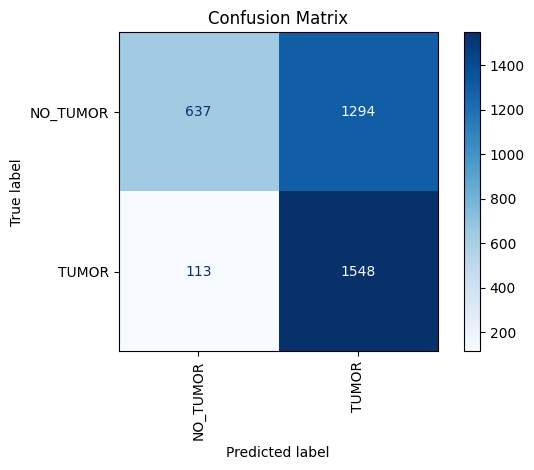

In [48]:
if df is not None:
    labels = sorted(df['true_label'].unique())
    y_true = df['true_label']
    y_pred = df['predicted_label']

    # 1) calcula a matriz de confusão (array NumPy)
    cm = confusion_matrix(y_true, y_pred, labels=sorted(df['true_label'].unique()))

    # 3) plota um heatmap gráfico
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [49]:
if df is not None:
    # extrai y_true, y_pred
    y_true = df['true_label']
    y_pred = df['predicted_label']

    # lista de classes como strings, na ordem alfabética (ou qualquer outra ordem que você prefira)
    classes = sorted(df['true_label'].unique())

    # 4) métricas globais
    acc       = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall    = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1        = f1_score(y_true, y_pred, average='macro', zero_division=0)
    mcc       = matthews_corrcoef(y_true, y_pred)
    report    = classification_report(y_true, y_pred, zero_division=0)

    print(f"Acurácia:   {acc:.3f}")
    print(f"Precisão:   {precision:.3f}")
    print(f"Recall:     {recall:.3f}")
    print(f"F1-Score:   {f1:.3f}")
    print(f"MCC:        {mcc:.3f}\n")
    print("Classification Report:\n")
    print(report)

    # 5) especificidade por classe
    #    TN = total de acertos fora da classe i
    #    FP = total de predições i que estavam erradas
    specificity = {}
    total = cm.sum()
    for i, cls in enumerate(classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = total - (tp + fp + fn)
        specificity[cls] = tn / (tn + fp) if (tn + fp) > 0 else 0

    print("Especificidade por classe:")
    for cls, spec in specificity.items():
        print(f"  {cls:>10s}: {spec:.3f}")

Acurácia:   0.581
Precisão:   0.465
Recall:     0.409
F1-Score:   0.378
MCC:        0.303

Classification Report:

              precision    recall  f1-score   support

        ERRO       0.00      0.00      0.00         0
    NO_TUMOR       0.85      0.31      0.45      2079
       TUMOR       0.54      0.92      0.68      1683

    accuracy                           0.58      3762
   macro avg       0.46      0.41      0.38      3762
weighted avg       0.71      0.58      0.55      3762

Especificidade por classe:
    NO_TUMOR: 0.932
       TUMOR: 0.330
